# MRI - Alzheimer Stage Classifier
### by Haim Elbaz & Asaf Levi


## Introduction
The goal of this project is to provide a tool to classify MRI images of alzheimer patients into the different stages of the disease, characterized by dementia severity levels. 

To accomplish this, We will build a CNN model using PyTorch and train it with data obtained from kaggle:

https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images


## Data Description

## Data Praparation & Preprocessing

The dataset is already split into a train & test sub-sets. 
Within the directories of these sets, the images are arranged in subdirectories named after the class. The image file name indicates an image's unique ID. 

PyTorch's ImageFolder dataset subclass fits exactly this arrangement. 

In [1]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from helper import show_images

In [2]:
TRAINPATH = "Alzheimer_s Dataset/train/"
TESTPATH  = "Alzheimer_s Dataset/train/"

In [3]:
transformer = transforms.Compose([transforms.Resize((208, 176)),
                                transforms.CenterCrop((188, 156)),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder(TRAINPATH, transform=transformer)
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

In [4]:
loader = DataLoader(dataset, batch_size=32, shuffle=True)

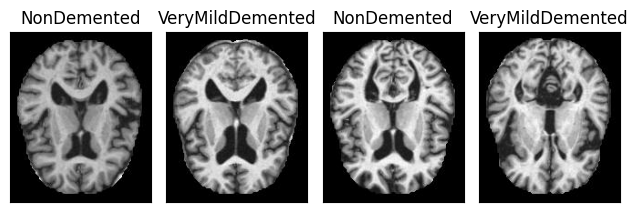

In [5]:
img, labels = next(iter(loader))
show_images([img[i] for i in range(4)], labels, idx_to_class)